<a href="https://colab.research.google.com/github/c-daly/Notebooks/blob/main/SVD_LSI_NGRAM_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Assignment 3: n-gram Language Models, Word Sense disambiguation(LSA using SVD), LSTM**

### **Total points: 100**


# Q1. Latent Semantic Analysis (35 Points) 


 - A. Singular Value Decomposition (SVD) based distributed representation of text and documents. You can use python libraries for matrix decomposition (scipy). To demonstrate your work, use the example dataset (Table 2) of "R. A. Harshman (1990). Indexing by latent semantic analysis. Journal of the American society for information science". (10 Points)

 - B. Visualize (2-D) the documents and terms using library of your choice. (10 Points)

 - C. Implement a function that converts a query string to distributed representation and retrieves relevent documents. Visualize the the results as shown in Fig 1 of the paper. (10 Points)

## <CENTER>Task-1 (10 Points)

### Input data

In [ ]:
#Dataset
c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'
documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

### Perform preprocessing of documents

In the below cell remove punctuations and keep only words which belong to nltk corpus

In [ ]:
# TASK CELL
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):
  text = text.lower()
  text = re.sub(r"http\S+", "", text)
  text = re.sub(r"www.\S+", "", text)
  text_links_removed = "".join([char for char in text if char not in string.punctuation])
  text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
      if word not in stopword])
  text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
  text = word_tokenize(text)
  return text    

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Verify preprocessed data

In [ ]:
nltk.download('punkt')
clean_sent = []
clean_documents = []
for sent in documents:
    clean_sent = clean_text(sent)
    clean_documents.append(clean_sent)
    print(clean_sent)

original_documents = documents
documents = clean_documents

['human', 'machine', 'interface', 'lab', 'abc', 'computer', 'application']
['survey', 'user', 'opinion', 'computer', 'system', 'response', 'time']
['eps', 'user', 'interface', 'management', 'system']
['system', 'human', 'system', 'engineering', 'testing', 'eps']
['relation', 'userperceived', 'response', 'time', 'error', 'measurement']
['generation', 'random', 'binary', 'unordered', 'tree']
['intersection', 'graph', 'path', 'tree']
['graph', 'minor', 'iv', 'width', 'tree', 'wellquasiordering']
['graph', 'minor', 'survey']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##### Expected Output
```CPP
['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']
```

### Assign names to document names
In the below cell create a list of document names. It will be later used to visualize documents

In [ ]:
def createDocName(documents):
  '''
  Input:
      documents: list of documents.
  Output:
      doc_names: a list of document names. 

  '''
  names =  ['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
  return names


In [ ]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


##### Expected Output
``` CPP
['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
```

### Words to Index mapping
Retrieve words from documents and create map of word and associate index to it

In [ ]:
def build_word_frequencies(documents):
  word_freq = {}  
  for document in documents:
    for word in document:
      word_freq[word] = word_freq.get(word, 0) + 1;
  return word_freq

def build_word_to_ix(documents, stopwords=None):
  """ 
  Input:
    documents: list of documents
    stopwords: list of stopwords
  Output:
    doc_names: map of words and assoicated index. 
  """ 
  words = {} 
  temp_word_counts = {}
  index = 0
  for document in documents:
    for word in document:
      if word not in words:
        if word_freq.get(word, 0) > 1:
          words[word] = index
          index += 1
  return words


In [ ]:
word_freq = build_word_frequencies(documents)
word_to_ix = build_word_to_ix(documents, stopwords)
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'eps': 8, 'tree': 9, 'graph': 10, 'minor': 11}


##### Expected Output
```CPP
{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'survey': 4, 'system': 5, 'time': 6, 'response': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}
```

### Document-Terms count matrix

In [ ]:
def get_word_count_by_document(word, document):
  count = 0
  for search_word in document:
    if search_word == word:
      count += 1
  return count

def build_td_matrix(documents, word_to_ix):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
    Output:
        td_matrix: matrix of count of words in documents, each row 
            represent a word and each column represent a document

    '''

    td_matrix = []
    for word, index in word_to_ix.items():
      word_row = []
      for document in documents:
        word_row.append(get_word_count_by_document(word, document))
      td_matrix.append(word_row)
    return td_matrix


In [ ]:
X = np.array(build_td_matrix(documents, word_to_ix))
print(X)

[[1 0 0 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1]
 [0 1 1 0 0 0 0 0 0]
 [0 1 1 2 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [0 1 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 1 1]]


##### Expected Output
```CPP
[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 ```

### Singular Value Decomposition
Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix
- To perform the singular value decompostion please check tutorial:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [ ]:
def svd(documents, word_to_ix, rank):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
        rank: number of colums/rows to retain in decomposed matrix
    Output:
        Uk: term singular vector matrix
        Sk: singular value matrix
        Vk_t: transpose of document singular vector matrix
    '''
    Uk, Sk, Vk_t = np.linalg.svd(X)
    Sk = np.diag(Sk)
    return Uk[:,:rank], Sk[:rank,:rank], Vk_t.T[:,:rank]

In [ ]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.24996905 -0.08382403]
 [-0.21198183 -0.05879672]
 [-0.24432508  0.04163819]
 [-0.20420593  0.26961464]
 [-0.32402635  0.01416911]
 [-0.69168389 -0.1221513 ]
 [-0.21924852  0.08307387]
 [-0.21924852  0.08307387]
 [-0.32967032 -0.1112931 ]
 [-0.01471931  0.50401961]
 [-0.03936203  0.63815168]
 [-0.0342975   0.46098478]]
[[3.26779047 0.        ]
 [0.         2.53906797]]
[[-0.21613257 -0.0397715 ]
 [-0.58227059  0.14549369]
 [-0.47657964 -0.10951735]
 [-0.6007139  -0.1730634 ]
 [-0.13418762  0.06543651]
 [-0.00450436  0.19850576]
 [-0.01654982  0.4498388 ]
 [-0.02704544  0.63139549]
 [-0.0850316   0.53907619]]


##### Expected Output
```CPP 
[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.40359886  0.05707026]
 [-0.20591786  0.27364743]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]
 ```

## <CENTER>Task-2 (10 Points)

### Visualize documents in 2D space

[[-0.70627596 -0.10098255]
 [-1.90273829  0.36941838]
 [-1.5573624  -0.278072  ]
 [-1.96300715 -0.43941972]
 [-0.43849703  0.16614774]
 [-0.01471931  0.50401961]
 [-0.05408134  1.14217129]
 [-0.08837884  1.60315606]
 [-0.27786546  1.36875109]]


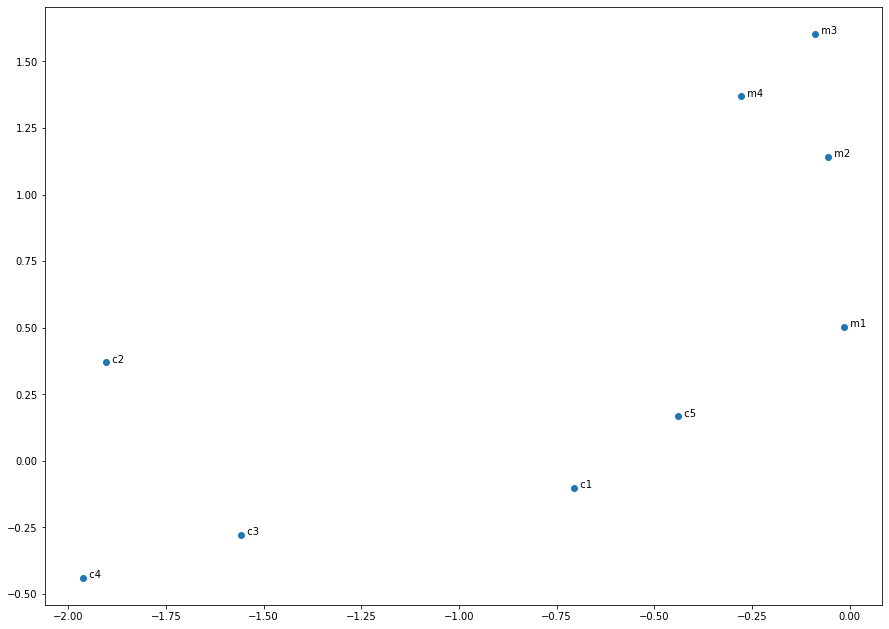

In [ ]:
#Visualize documents and print coordinates
plt.rcParams["figure.figsize"] = (15,11)
VS = np.dot(Vk_t, Sk)
x = VS[:,0]
y = VS[:,1]

print(VS)
fig, ax = plt.subplots()

ax.scatter(x,y)
for i, txt in enumerate(docName):
    ax.annotate("  " + txt, (x[i], y[i]))

##### Expected
```CPP
[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]
```
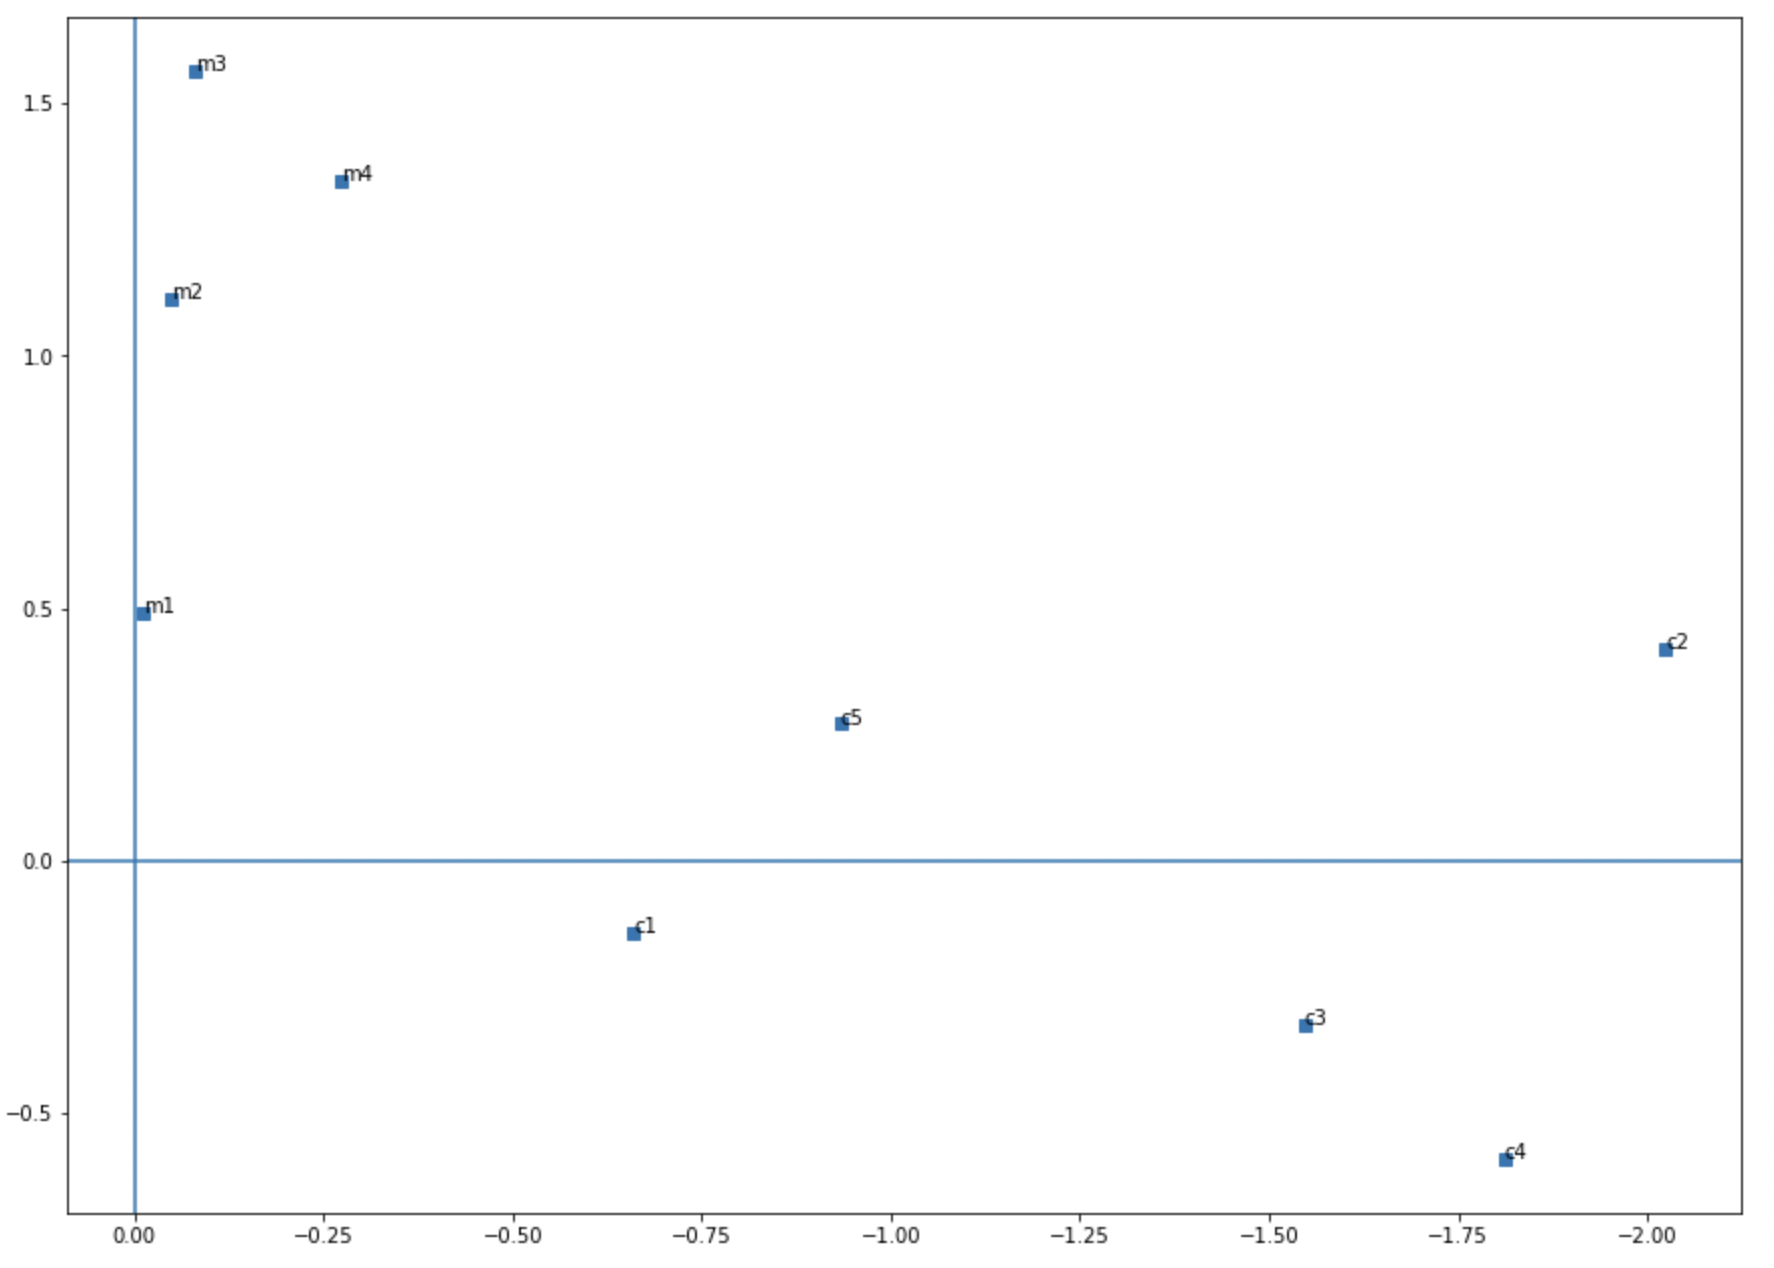

### Visualize terms in 2D space

[[-0.81684647 -0.2128349 ]
 [-0.69271221 -0.14928886]
 [-0.79840316  0.10572219]
 [-0.66730219  0.68456989]
 [-1.05885023  0.03597634]
 [-2.26027802 -0.31015045]
 [-0.71645821  0.2109302 ]
 [-0.71645821  0.2109302 ]
 [-1.07729354 -0.28258075]
 [-0.04809962  1.27974005]
 [-0.12862686  1.62031048]
 [-0.11207705  1.17047168]]


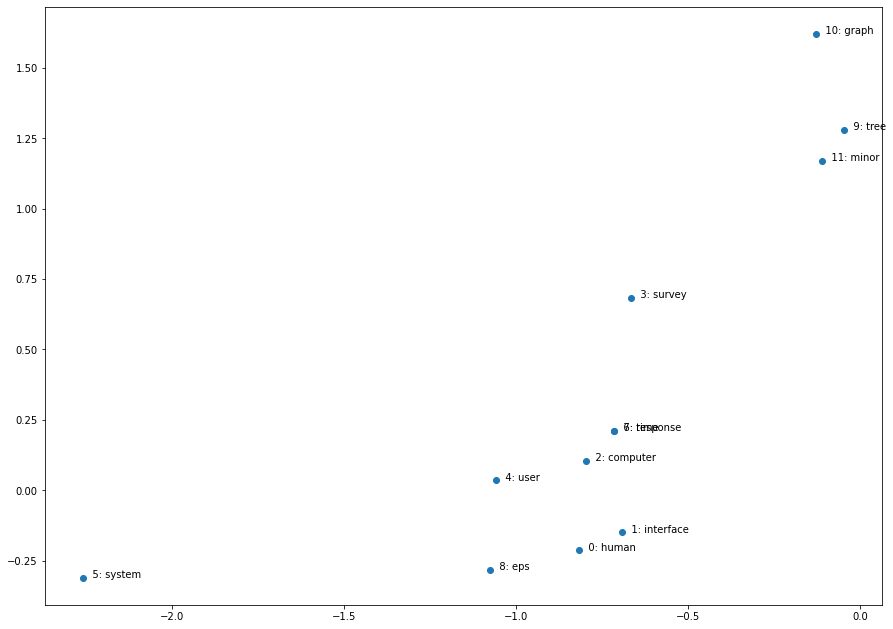

In [ ]:
#Visualize terms and print coordinates
US = np.dot(Uk, Sk)
print(US)
x = US[:,0]
y = US[:,1]

fig, ax = plt.subplots()

ax.scatter(x,y)
words = [(key, value) for key, value in word_to_ix.items()]
for i, txt in enumerate(words):
    ax.annotate("   " + str(txt[1]) + ": " + txt[0], (x[i], y[i]))

##### Expected
```CPP
[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-1.34837689  0.14505553]
 [-0.68794764  0.69552995]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]
```
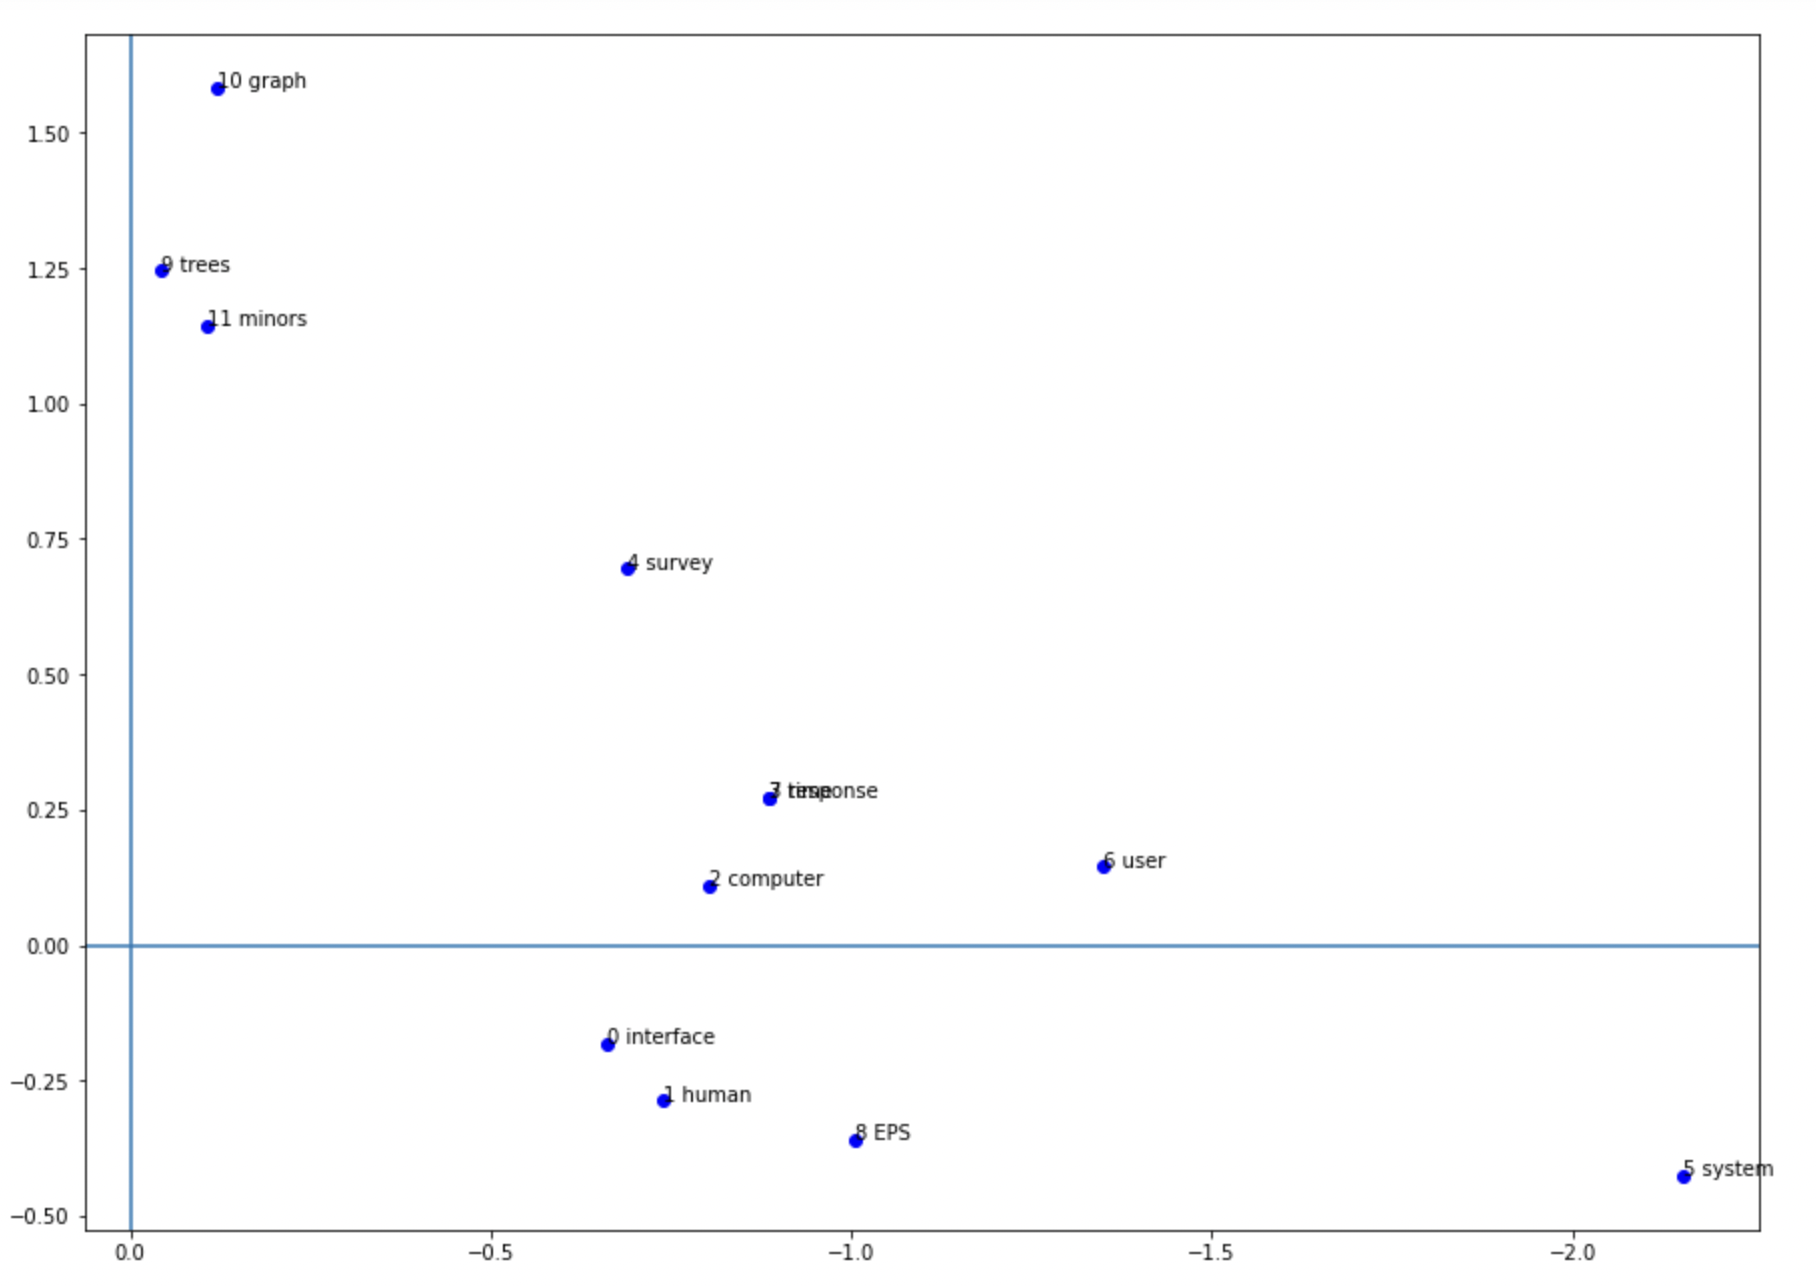

## <CENTER>Task-3 (10 Points)

### Find matching documents for given document

In [ ]:
# Hint create query vector for input document. Calculate its cosine distance from other document
def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
    '''
    Input:
        s:query document.
        Uk:Term matrix
        Sk:singular value matrix
        Vk_t:Document matrix
        word_to_ix: {word, index} map
        documents:list of document
        min_score:min score beyond which documents are considerd matching
    Output:
        q_hat: coordinates of query vector
        matches: list of tuples containing matching document and its score
    '''
    # query word count
    qwc = {}
    for word in clean_text(s):
      qwc[word] = qwc.get(word, 0) + 1
   
    print(qwc)
    query_representation = []

    for word, index in word_to_ix.items():
      word_row = []
      query_representation.append(qwc.get(word,0))
    
    q_hat = query_representation

    US_inv = np.dot(Uk,np.linalg.inv(Sk))
    q_hat = np.array(q_hat).T.dot(US_inv)
  
    x1 = VS[:,0]
    y1 = VS[:,1]
  
    #fig, ax = plt.subplots()
  
    # plot docs
    matches = []
    for i, txt in enumerate(docName):
      doc = [x1[i], y1[i]]
      num = np.dot(doc, q_hat)
      den = np.linalg.norm(doc) * np.linalg.norm(q_hat)
      cos_sim = num/den
      if cos_sim > .9:
        matches.append((original_documents[i], num/den))
        
    return q_hat, matches

In [ ]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

{'human': 1, 'computer': 1, 'interaction': 1}
[-0.15126249 -0.01661469]
[('Human machine interface for Lab ABC computer applications', 0.9994681850839183), ('A survey of user opinion of computer system response time', 0.9549910411958468), ('The EPS user interface management system', 0.9977369100454693), ('System and human system engineering testing of EPS', 0.9938659356023731)]


##### Expected
```CPP
[-0.461821   -0.07002767]
[('The EPS user interface management system', 0.9984452813340272), ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('System and human system engineering testing of EPS', 0.9865886405556598), ('A survey of user opinion of computer system response time', 0.9374863669686595), ('Relation of user-perceived response time to error measurement', 0.9075594362644345)]
```

### Visual representation of query/document

{'human': 1, 'computer': 1, 'interaction': 1}
0.9994681850839183
0.9549910411958468
0.9977369100454693
0.9938659356023731
0.8908473178448049
-0.08012006839989724
-0.062047450675908576
-0.054302571148678445
0.09075816822927077


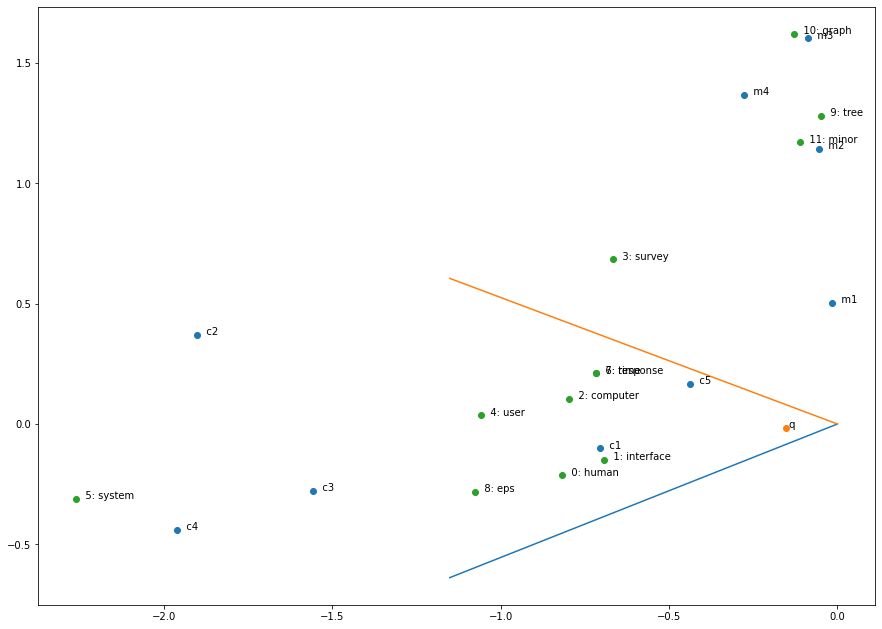

In [ ]:
# Plot terms, documents and query documents along with lines representing its cosine angle 
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
US_inv = np.dot(Uk,np.linalg.inv(Sk))
#q_hat = np.array(q_hat).T.dot(US_inv)

x1 = VS[:,0]
y1 = VS[:,1]

fig, ax = plt.subplots()

# plot docs
dots = []
for i, txt in enumerate(docName):
  doc = [x1[i], y1[i]]
  num = np.dot(doc, q_hat)
  #dots.append(den)
  den = np.linalg.norm(doc) * np.linalg.norm(q_hat)
  print(num/den)

#print(dots)

ax.scatter(x1,y1)
for i, txt in enumerate(docName):
    ax.annotate("   " + str(txt), (x1[i], y1[i]))
    
x2 = q_hat[0]
y2 = q_hat[1]

ax.scatter(x2,y2)
ax.annotate(" q", (x2,y2))

# plot words
dataW = np.dot(Uk, Sk)

xW = dataW[:,0]
yW = dataW[:,1]

ax.scatter(xW,yW)
words = [(key, value) for key, value in word_to_ix.items()]
for i, txt in enumerate(words):
    ax.annotate("   " + str(txt[1]) + ": " + txt[0], (xW[i], yW[i]))
  
 
ax = plt.gca()
point1 = [0, 0]
point2 = [-1 + q_hat[0], -1 * np.cos(.9) + q_hat[1] ]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values)

point3 = [0, 0]
point4 = [-1 + q_hat[0], 1 * np.cos(.9) + q_hat[1]]
x_values1 = [point3[0], point4[0]]

y_values1 = [point3[1], point4[1]]

plt.plot(x_values1, y_values1)

##### Expected

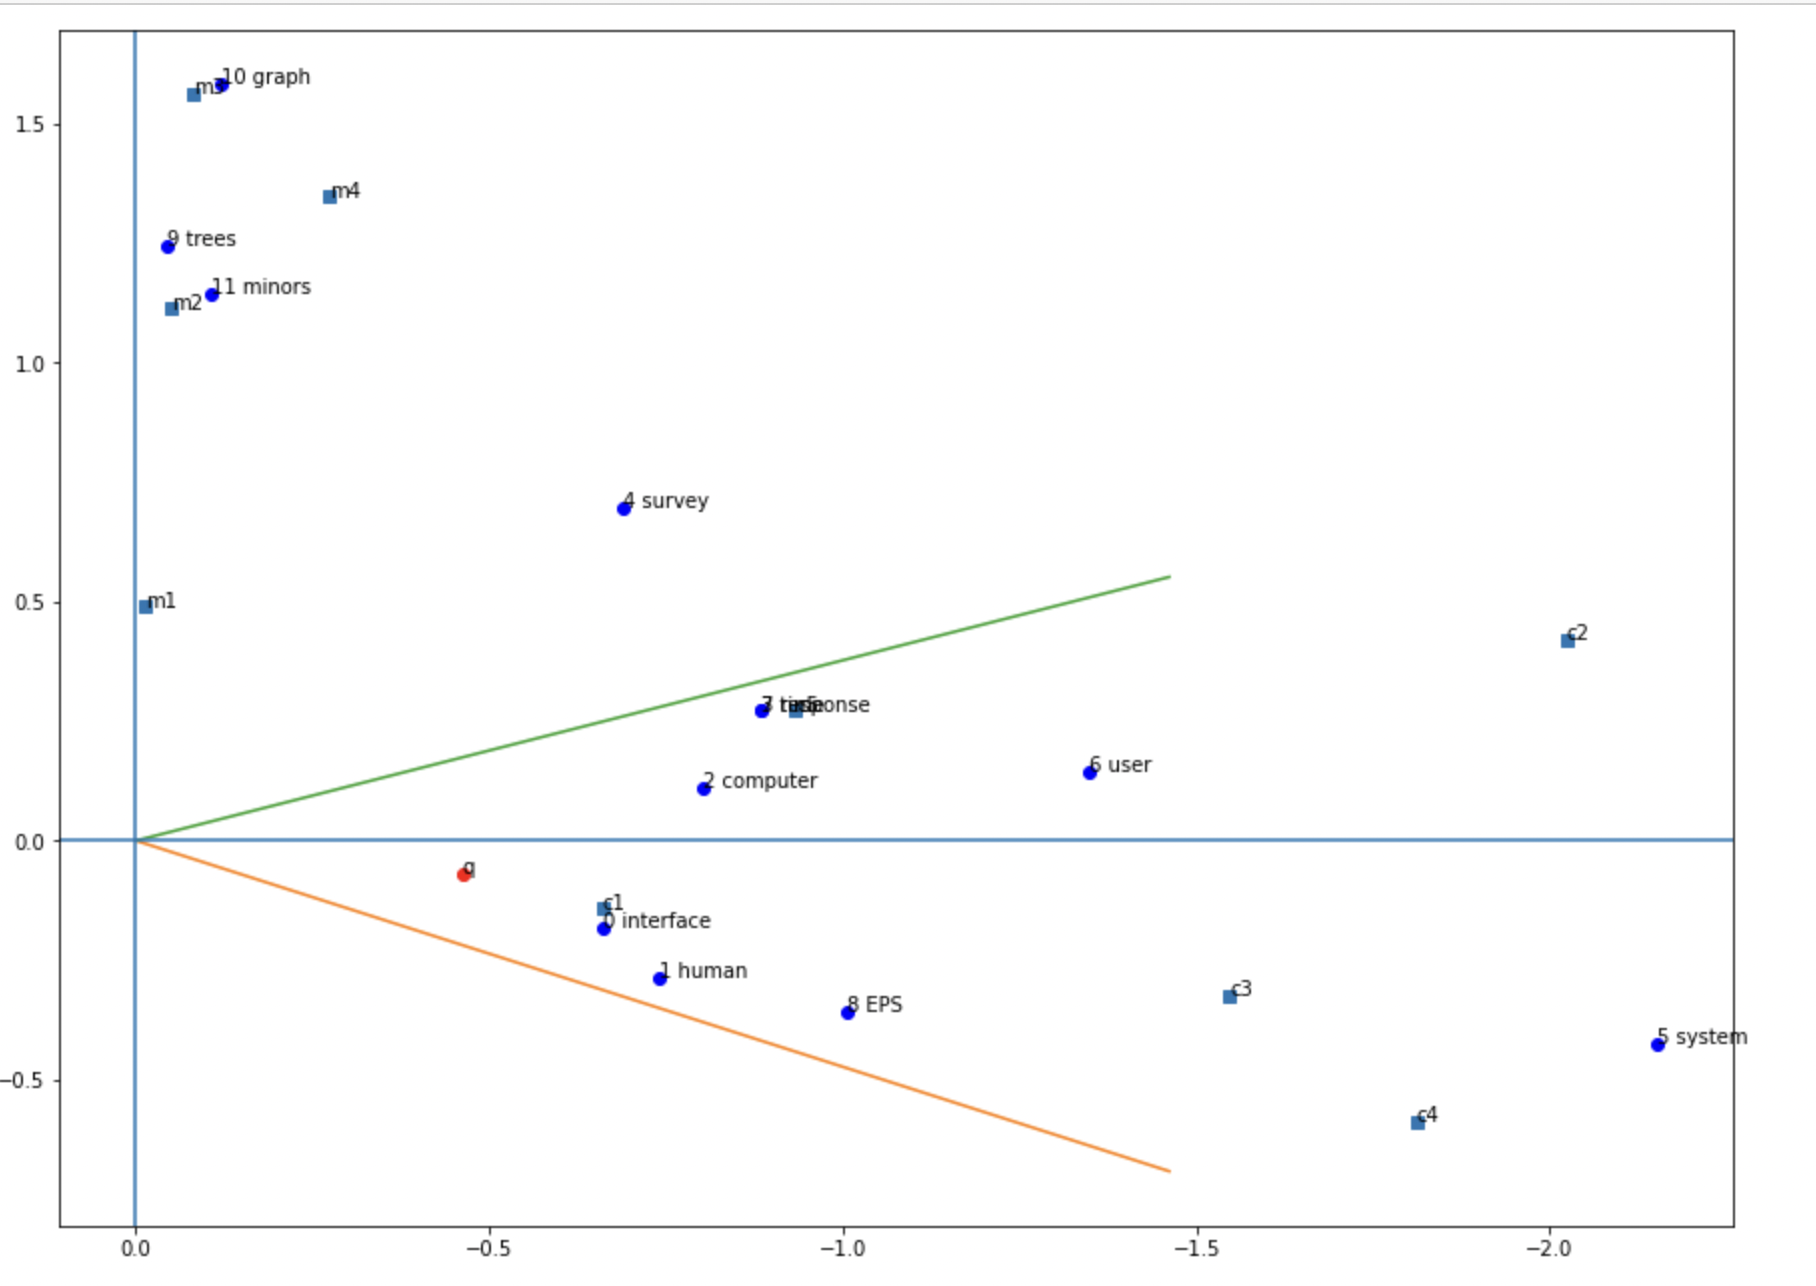


## **Theory questions: (5 points)**
- A) Give short description of Left-eigen vectors, right-eigen vectors and eigen-values matrix retured by Singular Value Decompostion of document-terms count matrix.
- B) Visually represent the document "Graph and tree generation" in 2D space along with words and documents as given in previous question.

A: The left eigenvector is U, and corresponds to the rows in our term-document matrix, thus representing term eigenvectors.  It is X * X.T. The right eigenvectors correspond to the documents and are determined by X.T * X

{'graph': 1, 'tree': 1, 'generation': 1}


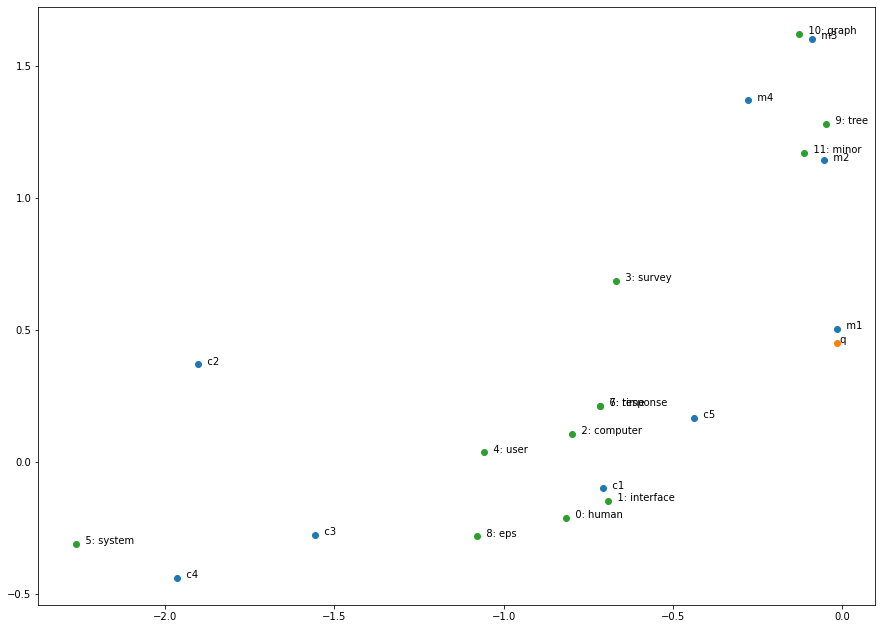

In [ ]:
# Plot terms, documents and query documents along with lines representing its cosine angle 
q_hat, matches = query('Graph and tree generation', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
US_inv = np.dot(Uk,np.linalg.inv(Sk))

x1 = VS[:,0]
y1 = VS[:,1]

fig, ax = plt.subplots()

# plot docs
dots = []
for i, txt in enumerate(docName):
  doc = [x1[i], y1[i]]
  num = np.dot(doc, q_hat)
  den = np.linalg.norm(doc) * np.linalg.norm(q_hat)

ax.scatter(x1,y1)
for i, txt in enumerate(docName):
    ax.annotate("   " + str(txt), (x1[i], y1[i]))
    
x2 = q_hat[0]
y2 = q_hat[1]

ax.scatter(x2,y2)
ax.annotate(" q", (x2,y2))

# plot words
dataW = np.dot(Uk, Sk)

xW = dataW[:,0]
yW = dataW[:,1]

ax.scatter(xW,yW)
words = [(key, value) for key, value in word_to_ix.items()]
for i, txt in enumerate(words):
    ax.annotate("   " + str(txt[1]) + ": " + txt[0], (xW[i], yW[i]))
  
 
#ax = plt.gca()
#point1 = [0, 0]
#point2 = [-1 + q_hat[0], -1 * np.cos(.9) + q_hat[1] ]
#x_values = [point1[0], point2[0]]
#y_values = [point1[1], point2[1]]
#plt.plot(x_values, y_values)

#point3 = [0, 0]
#point4 = [-1 + q_hat[0], 1 * np.cos(.9) + q_hat[1]]
#x_values1 = [point3[0], point4[0]]

#y_values1 = [point3[1], point4[1]]

#plt.plot(x_values1, y_values1)

# Q2. n-Gram Language Models

Your task is to train n-gram language models. [Ref SLP Chapter 3]

- Task 1: You will train unigram, bigram, and trigram models on given training files. Then you will score on given test files for unigram, bigram, and trigram. you will generate sentences from the trained model and compute perplexity.
- Task 2: You will create training data for n > 3. and Repeat the above task from training model.
<h6>Part-A = (55 Points) </h6>

In [ ]:
'''
Your imports go here
You are encouraged to implement your own functions and not use from library.
'''
import sys
from collections import Counter
import numpy as np

In [ ]:
# constants to define pseudo-word tokens
# access via UNK, for instance
# for this assignemnt we will follow <s> tag for beginning of sentence and
# </s> for end of senetence as suggested in SLP Book. Check sample training files for reference.
UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

We need to initialise global variables for model

In [ ]:

"""Initializes Parameters:
  n_gram (int): the n-gram order.
  is_laplace_smoothing (bool): whether or not to use Laplace smoothing
  threshold: words with frequency  below threshold will be converted to token
"""
# Initializing different object attributes
n_gram = 3 
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = None
threshold = 1
word_counts = Counter()


### Implement training function (10 points)

In [ ]:
def make_ngrams(tokens: list, vocab: list, n=3) -> list:
    """Creates n-grams for the given token sequence.
    Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    n_grams = []
    words = tokens
    ## Your code here 
    for i, word in enumerate(words):
      if word not in vocab:
        words[i] = UNK
      if i + n <= len(words):
        n_grams.append(tuple(words[i:i+n]))
    return n_grams

In [ ]:
def get_appropriate_start_string(n):
  return "<s> " * (n -1)
 
def get_appropriate_start_string_for_tri_file(n):
  # specifically for appending extra sentence markers to tri file
  return "<s> " * (n -3)
def train(training_file_path):
    """Trains the language model on the given data. Input file that
    has tokens that are white-space separated, has one sentence per line, and
    that the sentences begin with <s> and end with </s>
    Parameters:
      training_file_path (str): the location of the training data to read

    Returns:
    N Gram Counts, Vocab, N Minus 1 Gram Counts
    """
    vocab = []
    n_grams = []
    n_grams_minus_1 = []
    content = None
    with open(training_file_path, 'r') as fh:
      content = fh.read() # Read and split data to get list of words

    lines = content.split('\n')
    for line in lines:
    #  if n_gram == 6:
    #    start_words = "<s> <s> <s>"
    #    end_words = "</s> </s> </s>"
    #    line = start_words + ' ' + line + ' ' + end_words 
      #else:
      #  words = ''
      #  end_words = ''

      words = line.split(' ')
      word_counts.update(words)
    # Get the count of each word
    # Replace the words with <UNK> if count is < threshold(=1)
    for word, count in word_counts.items():
      if count >= threshold:
        vocab.append(word)

    # make use of make_n_grams function
    for line in lines:
      if n_gram > 3:
        start_words = get_appropriate_start_string_for_tri_file(n_gram) #SENT_BEGIN + ' ' * (n_gram -2) #"<s> <s> <s>"
        end_words =  SENT_END * (n_gram - 2) #"</s> </s> </s>"
        line = start_words + line + ' ' + end_words 
      result = make_ngrams(line.split(), vocab, n_gram) 
      n_grams += result
      # Get the training data vocabulary
      n_grams_minus_1 += make_ngrams(line.split()[1:-1], vocab, n_gram - 1)
    # For n>1 grams compute n-1 gram counts to compute probability
    n_gram_counts = Counter(n_grams)
    n_minus_1_gram_counts = Counter(n_grams_minus_1)
    return n_gram_counts, vocab, n_minus_1_gram_counts

Output your Trained Data Parameters:

In [ ]:
n_gram = 3
n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training-tri.txt")
print(n_gram_counts)
print(n_minus_1_gram_counts)
print(vocab)

Counter({('<s>', '<s>', 'i'): 1653, ('food', '</s>', '</s>'): 670, ('<s>', 'i', 'want'): 651, ('i', 'would', 'like'): 582, ('<s>', 'i', 'would'): 511, ('would', 'like', 'to'): 474, ('i', 'want', 'to'): 474, ('dollars', '</s>', '</s>'): 457, ('<s>', '<s>', "i'd"): 434, ('<s>', "i'd", 'like'): 422, ("i'd", 'like', 'to'): 409, ('over', '</s>', '</s>'): 367, ('start', 'over', '</s>'): 366, ('like', 'to', 'eat'): 365, ('restaurant', '</s>', '</s>'): 286, ('<s>', '<s>', 'tell'): 282, ('<s>', 'tell', 'me'): 281, ('tell', 'me', 'about'): 248, ('<s>', '<s>', 'start'): 237, ('<s>', 'start', 'over'): 237, ('dinner', '</s>', '</s>'): 224, ('want', 'to', 'eat'): 199, ('like', 'to', 'have'): 197, ('<s>', '<s>', "let's"): 196, ('<s>', '<s>', 'uh'): 184, ('<s>', '<s>', "i'm"): 178, ('lunch', '</s>', '</s>'): 175, ('<s>', '<s>', 'what'): 172, ('<s>', '<s>', 'do'): 166, ('<s>', "let's", 'start'): 163, ('<s>', '<s>', 'can'): 160, ('like', 'to', 'go'): 156, ('<s>', '<s>', 'the'): 147, ('restaurants', '</s

### Scoring function (points 5):
Implement Score function that will take input sentence and output probability of given string representing a single sentence.

In [ ]:
def score(sentence):
    """Calculates the probability score for a given string representing a single sentence.
    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    prob = 1
    # Split the input sentence and replace out of vocabulary tokens with <UNK>     
    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    n_grams = make_ngrams(sentence.split(), vocab, n_gram)
    num_gram = None
    den_gram = None
    num = 0
    den = 0
    prob = 1
    for temp_gram in n_grams:
      if temp_gram[:-1] == ('<s>', '<s>'):
        den_gram = temp_gram[1:]
      else:
        den_gram = temp_gram[:-1]
      num_gram = temp_gram
      num = n_gram_counts.get(num_gram, 0) + 1
      den = n_minus_1_gram_counts.get(den_gram, 0) + len(vocab)
      prob = prob * (num/den)
   
    return prob

In [ ]:
with open("hw2-test-tri.txt", 'r') as fh:
    test_content = fh.read().split("\n")
num_sentences_1 = len(test_content)
ten_sentences_1 = test_content[:10]
print("# of test sentences: ", num_sentences_1)
probablities = []

# of test sentences:  102


In [ ]:
# print probabilities/score of sentences in test content
for sentence in test_content:
  probablities.append(score(sentence))
probablities = np.array(probablities)
mean = np.mean(probablities)
std_dev = np.std(probablities)

### Sentence generation (10 points)
Generate sentence from the above trained model
- To generate next word from a set of probable n-grams and their probabilities check below tutorial:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [ ]:
def n_gram_starts_with(n_gram, fragment):
  temp_gram = n_gram[:-1]
  if temp_gram == fragment:
    return True
  return False

def get_candidate_n_grams(n_gram):
  candidates = []
  for temp_gram, count in n_gram_counts.items():
    if n_gram_starts_with(temp_gram, n_gram):
      candidates.append(temp_gram)
  
  return candidates

def generate_sentence(num_words=10):
    """Generates a single sentence from a trained language model using the Shannon technique.
      
    Returns:
      str: the generated sentence
    """
    # Start with <s> and randomly generate words until we encounter sentence end
    # Append sentence begin markers for n>2
    # Keep track of previous word for stop condition
    # Construct the (n-1) gram so far
    sentence_start = get_appropriate_start_string(n_gram) # [SENT_BEGIN for n in range(n_gram - 1)]
    n_minus_1_gram = tuple(sentence_start.strip().split(' '))
    sentence_start_string = sentence_start #SENT_BEGIN * (n_gram-1)
    sentence_end_string = SENT_END * (n_gram-2)
    prev_word = None
    candidate_counts = {}
    sentence_grams = []
    sentence_length = 10
    if n_gram > 1:
      while prev_word != "</s>": #and len(sentence_grams) <= sentence_length:
        candidates = get_candidate_n_grams(n_minus_1_gram)
        total_choice_count = 0
        candidate_counts = []
        # Get the counts of all available choices based on n-1 gram
        for temp_gram in candidates:
          choice_count = n_gram_counts.get(temp_gram, 0)
          total_choice_count += choice_count
          candidate_counts.append(choice_count)

        probabilities = []

        for count in candidate_counts:
          probabilities.append(count/total_choice_count)
        candidate_index = np.random.choice(len(candidate_counts), p=probabilities)
        new_gram = candidates[candidate_index]
        sentence_grams.append(new_gram)
        n_minus_1_gram = new_gram[1:]
        prev_word = new_gram[-1]

        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
    else:
      # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
      while prev_word != "</s>":
        continue
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word

    # Append sentence end markers for n>2
    sentence = [' '.join(value[-1] for value in sentence_grams)][0] 
    #for i, value in enumerate(sentence_grams):
    #  print(value[-1])
    return sentence_start_string + ' ' + sentence + ' ' + sentence_end_string

In [ ]:
generate_sentence()

'<s> <s>  i want to eat on saturday night </s> </s>'

In [ ]:
def generate(n):
    """Generates n sentences from a trained language model using the Shannon technique.
    Parameters:
      n (int): the number of sentences to generate
      
    Returns:
      list: a list containing strings, one per generated sentence
    """
    # Generate sentences one by one and store
    sentences = []
    for x in range(n):
      sentences.append(generate_sentence())
    return sentences

In [ ]:
sentences = generate(50)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Sentences:
<s> <s>  can you start over </s> </s>
<s> <s>  uh don't care </s> </s>
<s> <s>  tell me more about won thai cuisine </s> </s>
<s> <s>  tell me more information about taqueria de berkeley have margaritas </s> </s>
<s> <s>  i would like to um eat next tuesday uh say between seven and eight o'clock in the area </s> </s>
<s> <s>  give me a list of oh indian restaurants </s> </s>
<s> <s>  okay i'm looking for a japanese restaurant </s> </s>
<s> <s>  i would like to i have the list again </s> </s>
<s> <s>  let's start over </s> </s>
<s> <s>  start over again </s> </s>
<s> <s>  i own a bike </s> </s>
<s> <s>  i think i can get a reasonable price in a vegetarian </s> </s>
<s> <s>  i would like to see inexpensive indian restaurants please </s> </s>
<s> <s>  tell me more about bombay cuisine </s> </s>
<s> <s>  i can go up to forty bucks </s> </s>
<s> <s>  cost doesn't matter </s> </s>
<s> <s>  do you have any breakfast places are there any such thai restaurants you gave me before </s>

### Evaluate model perplexity (5 points)
Measures the perplexity for the test sequence with your trained model. 
you may assume that this sequence may consist of many sentences "glued together"

The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words.


In [279]:
# Since this sequence will cross many sentence boundaries, we need to include 
# the begin- and end-sentence markers <s> and </s> in the probability computation. 
# We also need to include the end-of-sentence marker </s> 
# but not the beginning-of-sentence marker <s>) in the total count of word tokens N

def perplexity(test_sequence):
    """.
    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of

    Returns:
      float: the perplexity of the given sequence
    """ 
    # Replace out of vocab words with <UNK>, already done in score function

    sentence_start_removed = re.sub('<s>*', '', test_sequence)
    n = len(set(sentence_start_removed.split()))
    print(score(test_sequence))
    # Remove sentence begin markers from data for computing N
    # Get the probability for the sequence
    perplexity = np.exp((-1/n) * np.log(score(test_sequence))) 
    return perplexity

In [280]:
# retraining after changing n_gram values
n_gram = 3 
n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training-tri.txt")
sentences = generate(12)
print(perplexity(" ".join(sentences[0:10])))

1.727782886824014e-239
74594.06981567576


Obviously got something wrong with the perplexity calculation, but not sure what.


### **Explore and explain: (5 points)**
* Experiment n_gram model for n = [1,2,3..7] of your choice. Explain the best choice of n that generates more meaninful sentences.


Code cells below show results of 3, 6, 7, and 25 -gram sentence generation.

It is true that using higher n results in a sentence that is more cohesive from beginning to end.  With the lower n, you expect to see some local cohesion, but with higher, you expect ideas to be carried through the sentence.  While I have found this to be true, it's not as pronounced as I would have thought.  I had to generate lots of sentences to sense whether or not n was increasing complexity.

For example, when I set it to 25, I found a couple of sentences with really distributed logic, like:

 *actually i'm taking my friend to dinner and she likes italian food*

  *okay howbout north african are there any north african restaurants* 

These sentences make it clear that the ngrams are providing a longer range for associating words together, but on the other hand, many of the utterances are short, and these aren't proper conversations.  So, some of the higher ngram sentences look as if they could have been generated by the lower.


In [ ]:
n_gram = 3 
n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training-tri.txt")
generate(5)

['<s> <s>  i would like to go to some mexican food </s> </s>',
 '<s> <s>  i would also um in addition to vegetarian i would like to know about any italian restaurant </s> </s>',
 '<s> <s>  start over </s> </s>',
 '<s> <s>  cafe fanny </s> </s>',
 "<s> <s>  i don't like chinese food </s> </s>"]

In [ ]:
n_gram = 6 
n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training-tri.txt")
generate(5)

['<s> <s> <s> <s> <s>  show me the list </s> </s></s></s></s>',
 "<s> <s> <s> <s> <s>  let's start over </s> </s></s></s></s>",
 '<s> <s> <s> <s> <s>  so which one of these places is really good </s> </s></s></s></s>',
 '<s> <s> <s> <s> <s>  twenty dollars </s> </s></s></s></s>',
 '<s> <s> <s> <s> <s>  like a listing for cheap meals very close to icsi open on sunday </s> </s></s></s></s>']

In [ ]:
n_gram = 7 
n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training-tri.txt")
generate(10)

['<s> <s> <s> <s> <s> <s>  i insist on an ethiopian restaurant </s> </s></s></s></s></s>',
 "<s> <s> <s> <s> <s> <s>  let's try cambodian food </s> </s></s></s></s></s>",
 '<s> <s> <s> <s> <s> <s>  yesterday </s> </s></s></s></s></s>',
 '<s> <s> <s> <s> <s> <s>  on christmas </s> </s></s></s></s></s>',
 '<s> <s> <s> <s> <s> <s>  where can i drink a coffee </s> </s></s></s></s></s>',
 "<s> <s> <s> <s> <s> <s>  when is la-val's open </s> </s></s></s></s></s>",
 '<s> <s> <s> <s> <s> <s>  which of these two restaurants serves uh southern indian cuisine </s> </s></s></s></s></s>',
 '<s> <s> <s> <s> <s> <s>  tell me about casa-de-eva </s> </s></s></s></s></s>',
 "<s> <s> <s> <s> <s> <s>  i'd like an italian restaurant </s> </s></s></s></s></s>",
 '<s> <s> <s> <s> <s> <s>  about half a mile </s> </s></s></s></s></s>']

In [ ]:
import regex as re
n_gram = 25 
n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training-tri.txt")
sentences = generate(10)
print("Generated sentences shown without start/end symbols")
for sentence in sentences:
  sentence = re.sub('<s>*', '', sentence)
  sentence = re.sub('</s>*', '', sentence)
  print(f"{sentence}\n")

Generated sentences shown without start/end symbols
                         it should cost no more than sixty dollars  

                         can you suggest a restaurant with spicy food  

                         no more than six dollars  

                         i would like to have fettucini for dinner  

                         not more than twenty dollars  

                         do you have any restaurants to recommend  

                         i want to eat lunch  

                         okay let's try san__francisco  

                         i want to find a really nice place to eat lunch next wednesday  

                         which ones have eggs  



# Q3. Classification using LSTM - using Tensorflow (30 Points)
In this part, we will be building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.<br>

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time to tweak your hyperparameters.
- Without a GPU, You might have to wait longer to experiment.

### Library Imports

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



### Visualizing data distribution (1 Point)


In [ ]:
## Reading the data and removing columns that are not important. 
dataset = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [ ]:
 #######################################################   
 # print head of data frame with help of head function # 
 #######################################################
 
print(dataset.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Petter Mattei's "Love in the Time of Money" is...  positive
4  Probably my all-time favorite movie, a story o...  positive


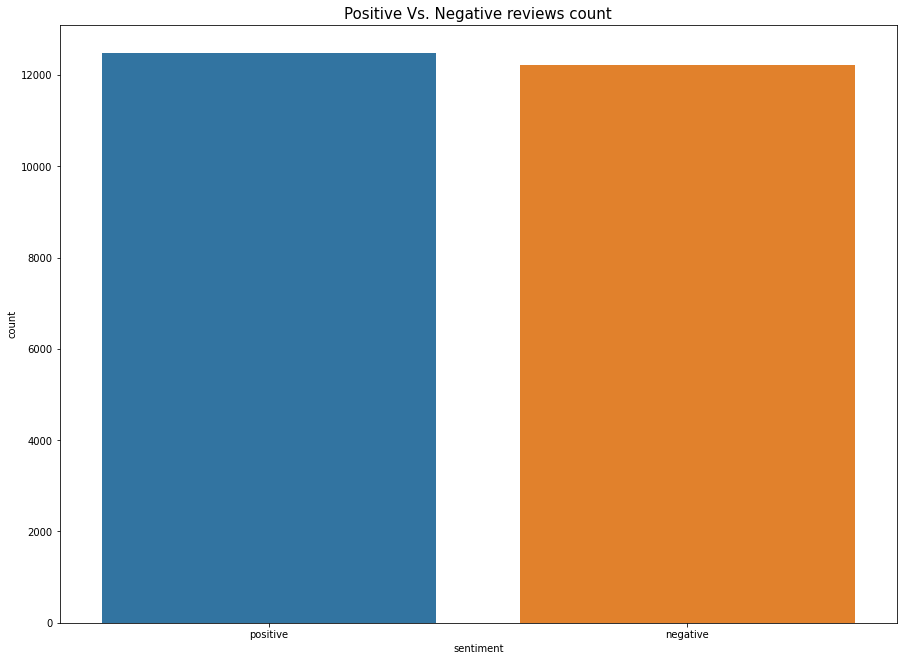

In [ ]:
 ####################################################### 
 # plot Positive Vs. Negative reviews count            # 
 #######################################################

sns.countplot(x=dataset["sentiment"])

plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()



### Cleaning the Reviews (2 Points)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
 #############################################################################################  
 # Clean all the reviews in the dataset using the clean_text function provided above         # 
 ############################################################################################# 
X = [] 
for review in dataset["review"]:
  X.append(clean_text(review))

In [ ]:
 #####################################################################
 # print head of the "CLEANED" data frame with help of head function # 
 #####################################################################
X_df = pd.DataFrame(X) 
print(X_df.head())

                                                   0
0  one reviewer mentioned watching 1 oz episode y...
1  wonderful little production br br filming tech...
2  thought wonderful way spend time hot summer we...
3  petter matteis love time money visually stunni...
4  probably alltime favorite movie story selfless...


### Splitting the dataset and Encoding Labels (2 Points)

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [ ]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, dataset['sentiment'], test_size=0.2, random_state=42)


In [ ]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_y_test = le.fit_transform(y_test)
encoded_y_train = le.fit_transform(y_train)

### Pre-Processing The Text (5 Points)
 

In [ ]:
# You can use the modules given below
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

MAX_SEQUENCE_LENGTH = 20
###############################################################################  
# Fit your tokenizer on the training reviews                                  #
###############################################################################
tokenizer =Tokenizer()
tokenizer.fit_on_texts(X_train)

#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                  #
#################################################################################################
word_index = tokenizer.word_index
vocabulary = set(word_index.keys())

#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
# HINT : convert training and validation reviews into sequences                                 #
#################################################################################################
X_train_indices = tokenizer.texts_to_sequences(X_train)

#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
# set maxlen = 200                                                                              #
#################################################################################################
# maxlen which is the maximum length of one review we will use for our training
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : {'contextualized', 'pepin', 'gumplike', 'ramses', '10yearold', 'roofsbr', 'frontaldiagonal', 'flicksand', 'spheeris', 'nowforgive', 'grimstead', 'invades', 'cavanagh', 'whimsey', '357', 'apatow', 'liquorthe', 'firmnessbr', 'egoistic', 'shopping', 'deviyaan', 'hocus', 'extrasbr', 'eammon', 'passion', 'realisticly', 'astronautstyle', 'flung', 'routinesbr', 'scold', 'vaguelybr', 'wasbetter', 'avaricious', 'fawn', 'malkovichbr', 'beretsbr', 'berliner', 'meethi', 'choppy', 'sullivanbr', 'vigilance', 'madeline', 'damnit', 'inners', 'ulfsak', 'slummingit', 'continuebr', 'boredomavoid', 'eating', 'monder', 'flashbackthe', 'escu', 'postwarbr', 'nazario', 'halfwit', 'prisonhe', 'imprisoned', 'celebrationsbr', 'fanbased', 'zeleznice', 'cavanaugh', 'trotskyite', 'occasionsbut', 'overjoyed', 'dehling', 'susana', 'cowboytype', 'meyerling', 'labelbr', 'rubens', 'altitude', 'hauptmann', 'nadia', 'wrestlemaniabr', '3hynkel', 'rubberized', 'schlockmeister', 'greenwhich', 'alothugh', 'walshs

### Using glove vectors for embedding (5 Points)

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.

To learn more about GloVe please read the following resource:
- https://nlp.stanford.edu/pubs/glove.pdf

In [ ]:
glove_dictionary = {}
with open('glove.6B.200d.txt') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [ ]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((len(vocabulary), 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################
for word, index in tokenizer.word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [ ]:
embedding_matrix.shape

(99734, 200)

Sample output : (99987, 200)

### Creating The Model (10)

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time.
- Without a GPU, You might have to wait longer to experiment.


Useful resources : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout <br>





In [290]:
import tensorflow as tf

tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):

  ''' 
  Arguments:
    embedding_matrix : a matrix with the corresponding embeddings
    of all words.

  Returns:
    The LSTM model that you created.
  '''
  
  model = tf.keras.Sequential()

  # TO DO: layer 1 : add embedding layer
  # The embedding layer maps the words to their embedding vectors from the embedding matrix
  embedding_layer = Embedding(len(vocabulary), 200, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)
  model.add(embedding_layer)

  # TO DO: layer 2 : add Bidirectional LSTM Layer 
  model.add(Bidirectional(LSTM(8,return_sequences=False)))

  # TO DO Add more layers : you can add more dense layers and dropout
  # NOTE : You should be able to achieve an validation accuracy greater than 85%
  #        within 10 epochs
  model.add(Dropout(0.5))
  model.add(Dense(16, activation='relu'))
  # TO DO Final layer : add output layer and activation 
  model.add(Dense(1, activation='sigmoid'))

  # TO DO : use a loss function, optimizer as adam to compile 
  # and evaluate model on auc,precision,recall,accuracy
  # HINT : choose your loss function based on the task (binary classification)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', Precision(), Recall(), AUC()])
  return model

In [291]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall
# NOTE : You should be able to achieve an validation accuracy greater than 85%
#        within 10 epochs

#################################################################
# Call the build_model function and initialize the model        #
#################################################################
model = build_model(embedding_matrix)
#######################################################################################################
# train and validate the model on the padded sequences of text which we have created initially        #
#######################################################################################################
print(model.summary())
history = model.fit(X_train, encoded_y_train, batch_size=16, epochs=10, verbose=1, validation_split=0.2)
model_score = model.evaluate(X_test, encoded_y_test, verbose=1)


Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 20, 200)           19946800  
                                                                 
 bidirectional_48 (Bidirecti  (None, 16)               13376     
 onal)                                                           
                                                                 
 dropout_66 (Dropout)        (None, 16)                0         
                                                                 
 dense_144 (Dense)           (None, 16)                272       
                                                                 
 dense_145 (Dense)           (None, 1)                 17        
                                                                 
Total params: 19,960,465
Trainable params: 13,665
Non-trainable params: 19,946,800
____________________________________

### Plotting Accuracy and Losses (5 Points)
 




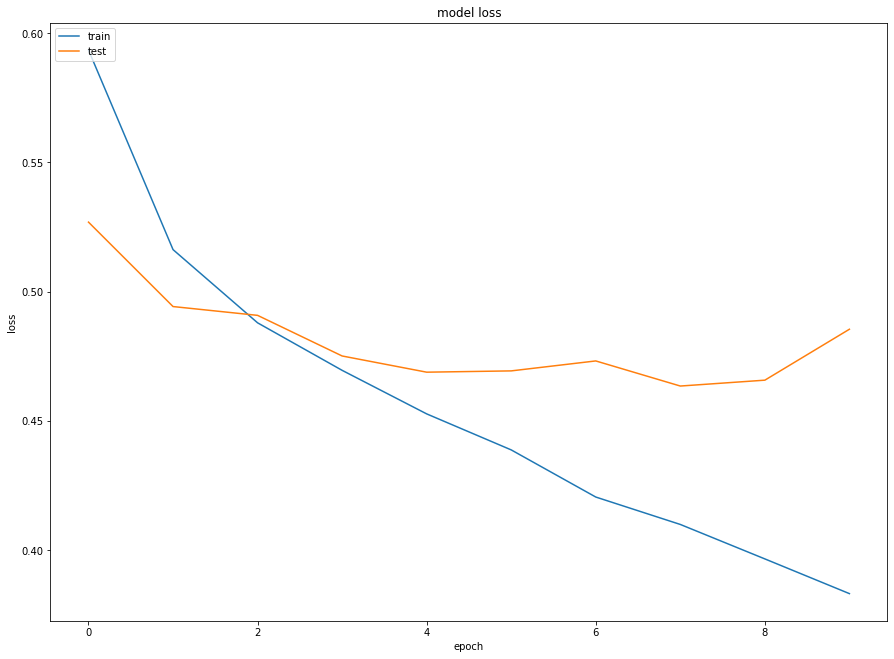

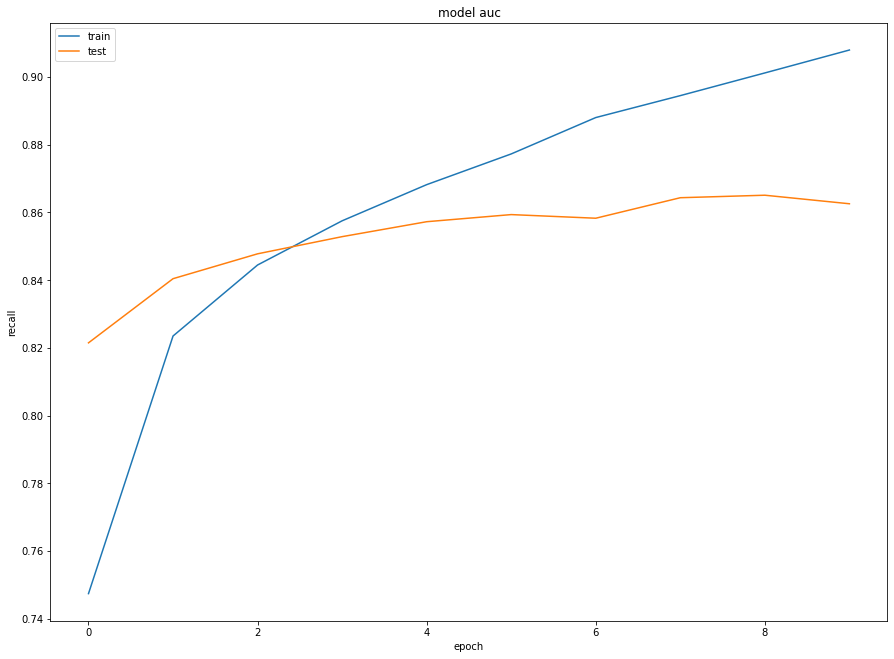

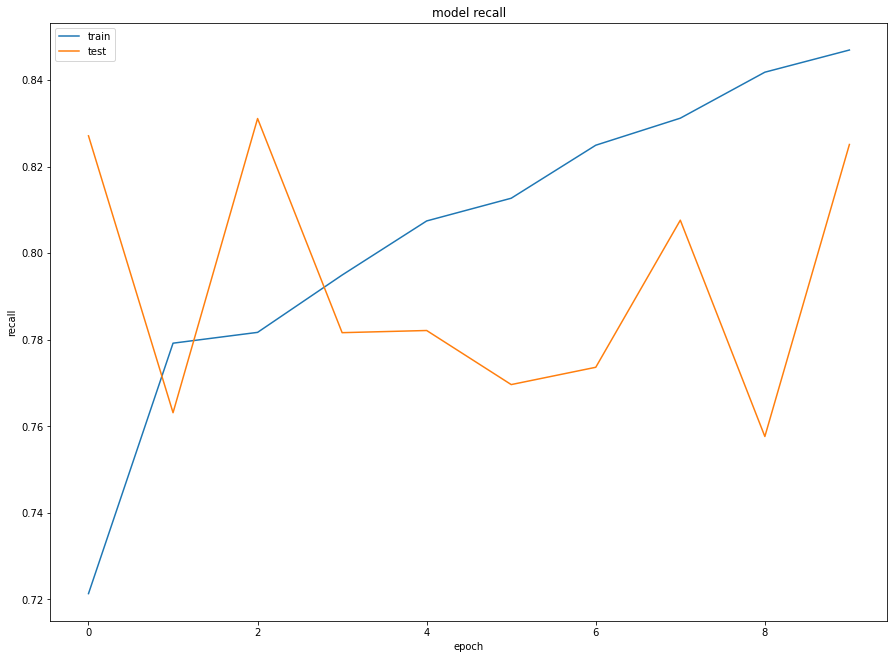

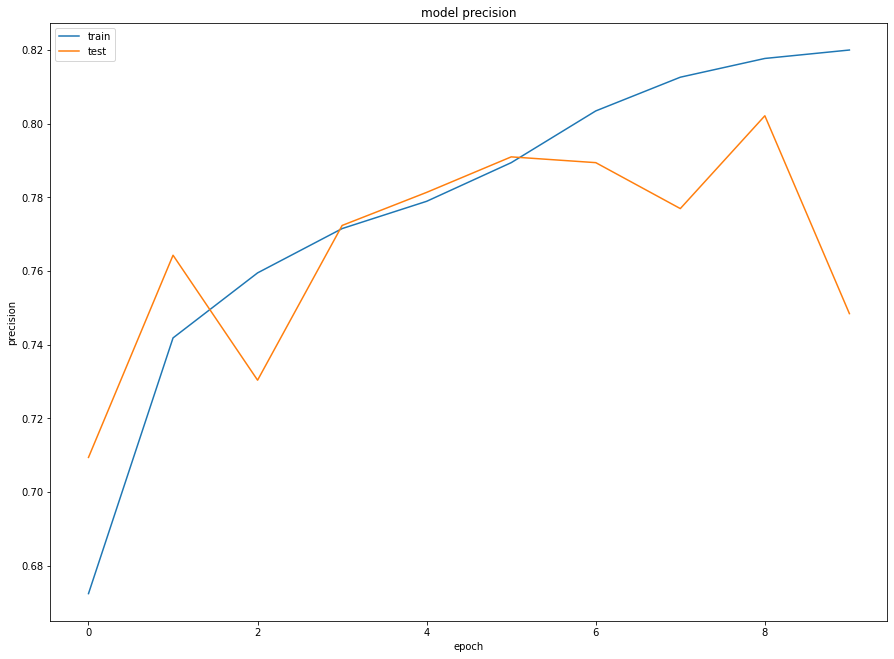

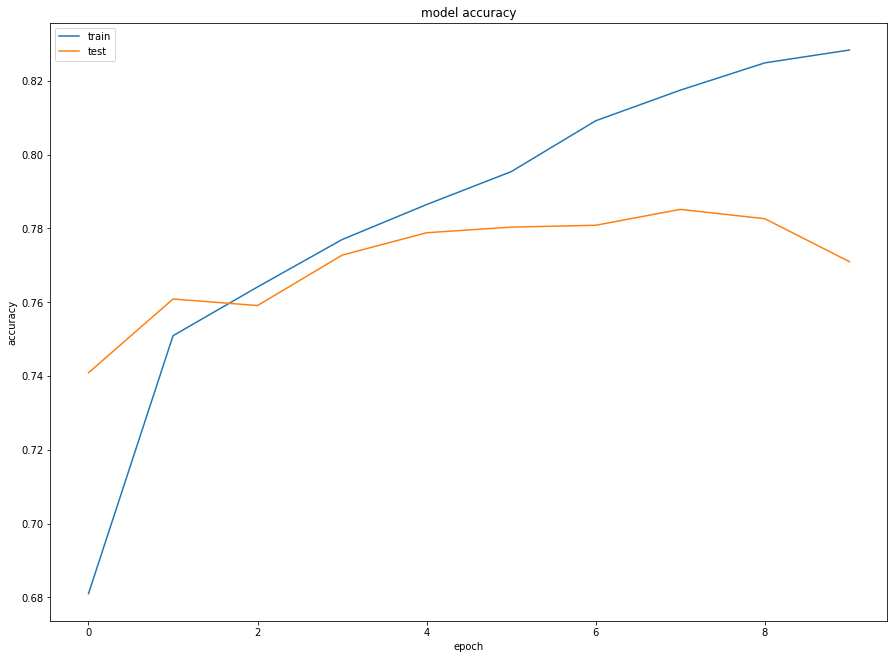

In [293]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['auc_48'])
plt.plot(history.history['val_auc_48'])

plt.title('model auc')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_48'])
plt.plot(history.history['val_recall_48'])

plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


plt.plot(history.history['precision_48'])
plt.plot(history.history['val_precision_48'])

plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [309]:
# You will need to include the pickled model along with the other submission files
# The saved model will be used to verify your lstm's predictions on hidden reviews

##################################################################################
# Save your trained model as a pickle file named "lstm_classifier"               #
# You will be using this saved model to make predictions in the next module      #
##################################################################################
model.save("lstm_classifier")

### Prediction (5 Points)

In [312]:
######################################################################
# Load your saved model                                              #
# Use the saved model to make predictions                            #
######################################################################
saved_model =  tf.keras.models.load_model("lstm_classifier")

In [321]:
# use the saved model to predict the reviews
def predict_review(review):
  '''
  Arguments:
    review : A single review for which you want to predict the sentiment for.
             example: "This movie was amazing! I would defenitely watch it again."

  Returns:
    The predicted sentiment for the review : either 1 or 0
  '''

 ############################################################################# 
 # Predict the sentiment for the given review using the model                #
 # that you trained and return the sentiment                                 #
 #                                                                           #
 # HINT : Remember that the review needs to be "preprocessed" before you use #
 # it for prediction                                                         #
 #############################################################################
  clean_review = clean_text(review)
  review_sequence = pad_sequences(tokenizer.texts_to_sequences(clean_review),
                        maxlen = MAX_SEQUENCE_LENGTH)
  
  return saved_model.predict(clean_review)


In [322]:
# Do not edit this cell

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:100]} -> {p}')
    

['like', 'original', 'gut', 'wrenching', 'laughter', 'like', 'movie', 'young', 'old', 'love', 'movie', 'hell', 'even', 'mom', 'liked', 'itbr', 'br', 'great', 'camp']


ValueError: ignored

### Expected Output:

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0 <br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0